# Tutorial 6.1: Bistability and Oscillations in a Firing-Rate Model with Feedback
### Neuroscience goal
 - learn how synaptic dynamics impacts the behavior of a bistable circuit with excitatory feedback
 - see how an approximate line attractor can behave as an integrator
### Computational goal
- practice simulating firing ate models

### Overview
- will explore conditions for bistability and effects of short-term synaptic plasticity in a firing-rate model with excitatory feedback
- three coupled variables for single unit will be:
    - firing rate, $r$
    - depression variable, $D$
    - synaptic gating variable, $s$

- equations to simulate:

    $\tau_r \frac{dr}{dt} = -r + f(S)$

    $\frac{dD}{dt} = \frac{1- D}{\tau_D} - p_rDr$

    $\frac{ds}{dt} = -\frac{s}{\tau_s} + \alpha_0Dp_rr \cdot(1 - s)$

- with additional condition $r \ge 0$ and
- total synaptic input, $S$, given by $S = W^{EE}s + s_{in}$

- firing rate curve, $f(S)$, corresponds to steady state firing rate as function of total synaptic input.
    - given as power law with saturation:

    $f(S) = r_0 + r_{max}\frac{S^x}{S^x + \sigma^s} $ if $S > 0$ and $f(S) = r_0$ if $S \leq 0$

- exponent is $x = 1.2$ and rate with no input is $r_0 = 0.1$Hz in first simulation
- max possible firing rate is $r_0 + r_{max}$, with $r_{max}$ = 100Hz
- input needed to reach midpoint of firing-rate range is $\sigma = 0.5$ 
- time constant for changes in firing rate is $\tau_r$ = 10ms

- for each question with a distinct parameter set, plot steady state response functions in the absence of input:
    - $f(W^{EE}s)$ as a function of $s$
    - $s(r) = \alpha_0Dp_rr\tau_s / (1 \alpha_0Dp_rr\tau_s)$ as a function of $r$

    - in the calculation of $s(r)$, will need to use steady state response of depression variable
        - $D(r) = 1 / (1 + p_rr\tau_D)$
    - after plotting steady state values as two distinct curves, will simulate system and response to transient inputs

In [47]:
import numpy as np
import matplotlib.pyplot as plt

In [60]:
tau_d = 0
tau_s = 2e-3
tau_r = 10e-3

r_max = 100
r0 = 0.1
x = 1.2
sigma = 0.5

alpha0 = 0.5
p_r = 1

dt = 1e-3
t = np.arange(0, 20, dt)

r = np.zeros_like(t)
D = np.ones_like(t)
s = np.zeros_like(t)


In [61]:
# define steady state functions

# f(S)
def f(S):
    if S > 0:
        return r0 + r_max * (S**x) / (S**x + sigma**x)
    else:
        return r0
    
def steady_state_D(r):
    return 1 / (1 + p_r * r * tau_d)

def total_syn_input(w_ee, s, s_in):
    return w_ee * s + s_in

# define differential equations

def dr_dt(r, S):
    return (-r + f(S)) / tau_r

def dd_dt(D, r):
    return (1 - D) / tau_d - p_r * D * r

def ds_dt(s, D, r):
    return -s / tau_s + alpha0 * D * p_r * r * (1 - s)

# get s(r) using steady state D(r)
def steady_state_s(r, D):
    return alpha0 * D * p_r * r * tau_s / (1 + alpha0 * D * p_r * r * tau_s)

### 1. fix depression variable so it remains 1 and set other parameters:
- alpha0 = 0.5
- w_ee = 8
- p_r = 1
- tau_s = 2ms

In [67]:
alpha0 = 0.5
w_ee = 8
p_r = 1
tau_s = 2e-3
s_in = 0

### 1a. 
- plot $f(W^{EE}s)$ for a range of values of $s$ from 0 to $1/W^{EE}$
- on the same figure, for a range of values of $r$ from 0 to $r_{max}$, plot $s(r)$, with $r$ on the y-axis and $s$ on the x-axis

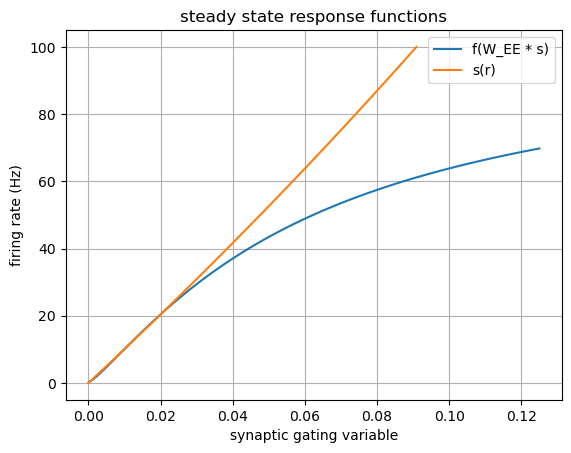

In [70]:
test_s = np.linspace(0, 1/w_ee, 100)
test_r = np.linspace(0, r_max, 100)

f_values = [f(total_syn_input(w_ee, s, s_in)) for s in test_s]
s_values = [steady_state_s(r, steady_state_D(r)) for r in test_r]

plt.plot(test_s, f_values, label='f(W_EE * s)')
plt.plot(s_values, test_r, label='s(r)')
plt.title('steady state response functions')
plt.xlabel('synaptic gating variable')
plt.ylabel('firing rate (Hz)')
plt.legend()
plt.grid(True)


### 1b
- simulate the full set of three coupled ODEs for 20s, with initial conditions:
    - r = 0
    - s = 0

- add temporary input strength $s_{in}$ = 0.05 for 50ms beginning at 10s
- plot resulting firing rate vs time
- check that stable rates correspond to crossing points of two curves from 1a.

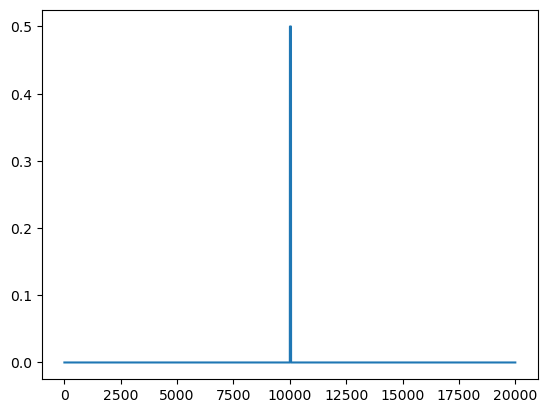

In [83]:
s_in = np.zeros_like(t)
s_in[int(len(t)/2):int((len(t)/2))+50] = 0.5
plt.plot(s_in)

In [98]:
def run_sim_no_dep(w_ee, s_in, r_init, D_init, s_init):
    r[0] = r_init
    D[0] = D_init
    s[0] = s_init

    for i in range(1, len(t)):
        S = total_syn_input(w_ee, s[i - 1], s_in[i])

        # update firing rate
        r[i] = r[i - 1] + dr_dt(r[i - 1], S) * dt
        # update depression variable
        D[i] = 1
        #D[i] = D[i - 1] + dd_dt(D[i - 1], r[i - 1]) * dt
        # update synaptic gating variable
        s[i] = s[i - 1] + ds_dt(s[i - 1], D[i - 1], r[i - 1]) * dt

        if r[i] < 0:
            r[i] = 0
    
    return r, D, s

In [99]:
r_sim, D_sim, s_sim = run_sim_no_dep(w_ee, s_in, 0, 1, 0)

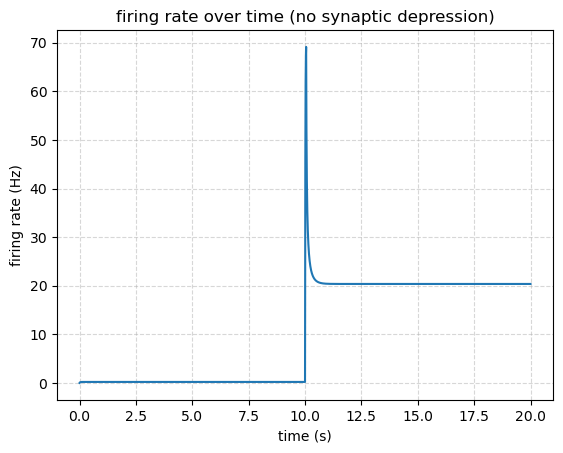

In [97]:
plt.plot(t, r_sim)
plt.title('firing rate over time (no synaptic depression)')
plt.xlabel('time (s)')
plt.ylabel('firing rate (Hz)')
plt.grid(True, linestyle='--', alpha=0.5)

# steady state crossover value matches 20Hz

### 2. include synaptic depression
- tau_d = 250ms
- p_r = 0.2
- r0 = 0.1Hz
- alpha0 = 0.5
- increase W_EE to 60
    - to compensate for reduced release probability and wakening of synapses due to depression
    

In [101]:
tau_d = 250e-3
p_r = 0.2
r0 = 0.1
alpha0 = 0.5
w_ee = 60

### repeat 1a, 1b
- set temporary input to be of strength = 0.002 and duration 2s

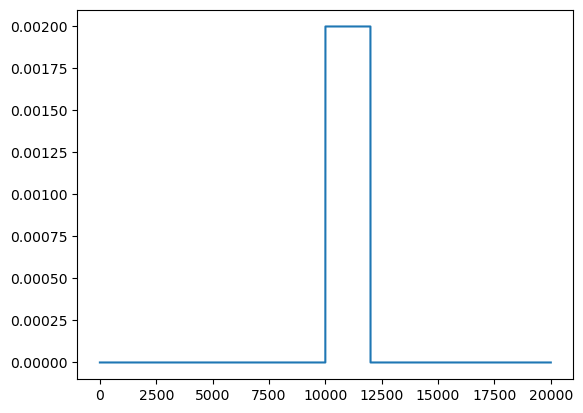

In [105]:
s_in = np.zeros_like(t)
half = int(len(t) / 2)
s_in[half:half+2000] = 0.002

plt.plot(s_in)

In [106]:
def run_sim(w_ee, s_in, r_init, D_init, s_init):
    r[0] = r_init
    D[0] = D_init
    s[0] = s_init

    for i in range(1, len(t)):
        S = total_syn_input(w_ee, s[i - 1], s_in[i])

        # update firing rate
        r[i] = r[i - 1] + dr_dt(r[i - 1], S) * dt
        # update depression variable
        D[i] = D[i - 1] + dd_dt(D[i - 1], r[i - 1]) * dt
        # update synaptic gating variable
        s[i] = s[i - 1] + ds_dt(s[i - 1], D[i - 1], r[i - 1]) * dt

        if r[i] < 0:
            r[i] = 0
    
    return r, D, s

In [107]:
r_sim, D_sim, s_sim = run_sim(w_ee, s_in, 0, 1, 0)

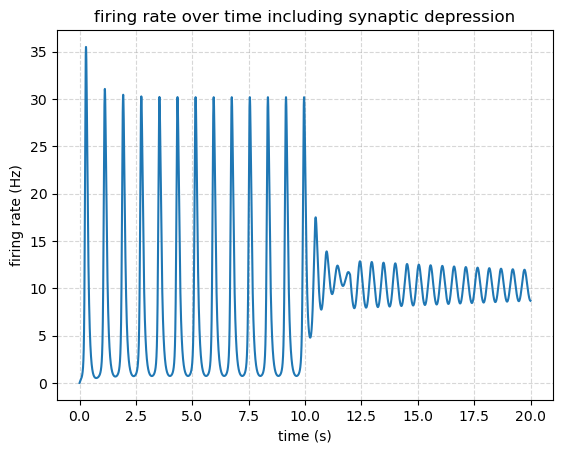

In [110]:
plt.plot(t, r_sim)
plt.title('firing rate over time including synaptic depression')
plt.xlabel('time (s)')
plt.ylabel('firing rate (Hz)')
plt.grid(True, linestyle='--', alpha=0.5)

# steady state crossover value matches 20Hz

### 3. repeat 1a, 1b with:
- p_r = 0.5
- w_ee = 35
- r0 = -0.1 Hz
- s_in = 0.05 for 50ms

In [148]:
p_r = 0.5
w_ee = 35
r0 = -0.1
tau_d = 250e-3
alpha0 = 0.25

s_in = np.zeros_like(t)
half = int(len(t) / 2)
s_in[half:half+50] = 0.05

In [149]:
r_sim, D_sim, s_sim = run_sim(w_ee, s_in, 0, 1, 0)

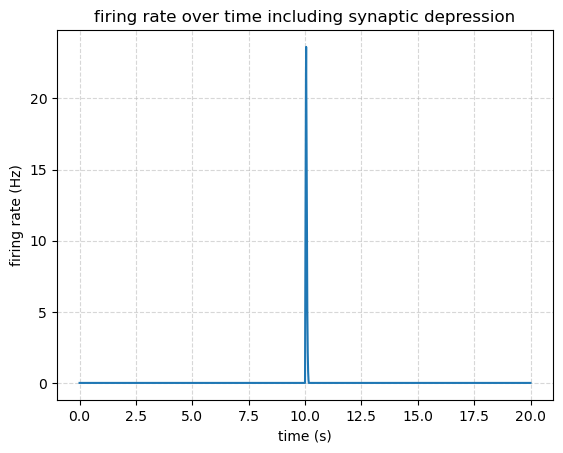

In [150]:
plt.plot(t, r_sim)
plt.title('firing rate over time including synaptic depression')
plt.xlabel('time (s)')
plt.ylabel('firing rate (Hz)')
plt.grid(True, linestyle='--', alpha=0.5)

### 3c
- r_init = 9Hz
- other init values to steady state at 9Hz

In [142]:
r_init = 9
d_init = steady_state_D(r_init)
s_init = steady_state_s(r_init, d_init)


In [143]:
r_sim, D_sim, s_sim = run_sim(w_ee, s_in, r_init, d_init, s_init)

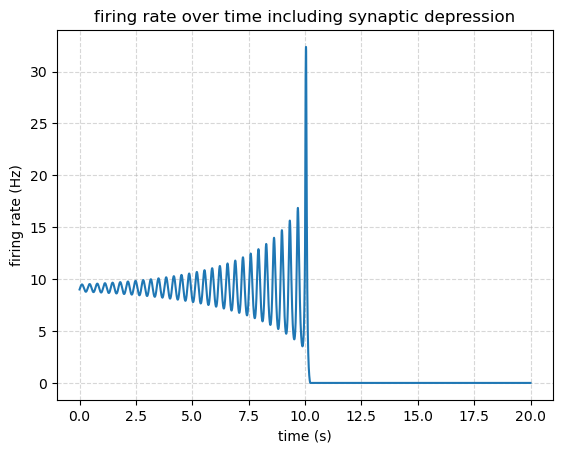

In [144]:
plt.plot(t, r_sim)
plt.title('firing rate over time including synaptic depression')
plt.xlabel('time (s)')
plt.ylabel('firing rate (Hz)')
plt.grid(True, linestyle='--', alpha=0.5)

### 4. slow negative feedback enhances oscillations
- repeat 3a, 3b, with:
    - tau_d = 125
    - alpha0 = 0.25
    - p_r = 1

In [145]:
tau_d = 125e-3
alpha0 = 0.25
p_r = 1

In [146]:
r_sim, D_sim, s_sim = run_sim(w_ee, s_in, 0, 1, 0)

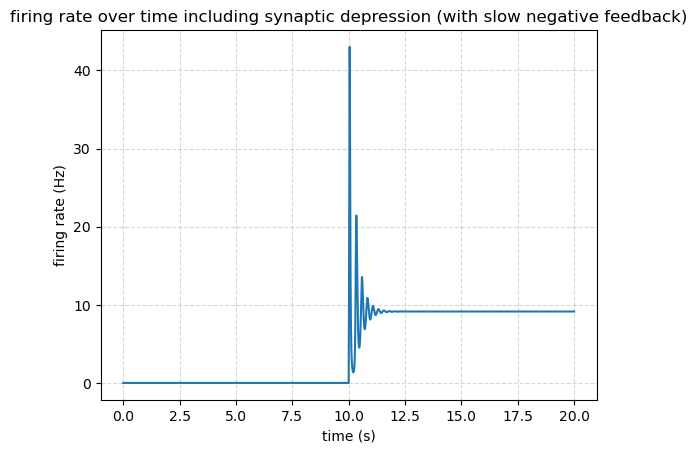

In [147]:
plt.plot(t, r_sim)
plt.title('firing rate over time including synaptic depression (with slow negative feedback)')
plt.xlabel('time (s)')
plt.ylabel('firing rate (Hz)')
plt.grid(True, linestyle='--', alpha=0.5)